<a href="https://colab.research.google.com/github/HalgasAdrian/CS5230-Coursework/blob/main/HW2B%20Clustering%20DBSCAN%2C%20Hierarchical%20Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**PROBLEM 5: DBSCAN on toy-neighborhood data**

You are to cluster, and visualize, a small dataset using DBSCAN epsilon = 7.5, MinPts = 3). You have been provided a file, dbscan.csv, that has the following columns for each point in the dataset:

cluster originally empty, provided for your convenience pt a unique id for each data point

x point x-coordinate

y point y-coordinate

num neighbors number of neighbors, according to the coordinates above neighbors the id’s of all neighbors within

As you can see, a tedious O(n^2) portion of the work has been done for you. Your job is to execute, point-by-point, the DBSCAN algorithm, logging your work.


In [20]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import display

In [21]:
# Loading data
url = 'https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/HW2/dbscan.csv'
data = pd.read_csv(url)  # Read into a DataFrame
print(data.head())  # Preview first few rows

# Convert to NumPy array (excluding non-numeric columns)
numeric_data = data.select_dtypes(include=['number']).to_numpy()
print(f"Numeric data shape: {numeric_data.shape}")

   cluster  pt          x          y  num_neighbors neighbors
0      NaN   0  51.418089  13.593610              2      0,27
1      NaN   1  39.132318  -4.419204              3   1,40,75
2      NaN   2  47.807515 -25.822561              1         2
3      NaN   3  27.699703  53.434193              1         3
4      NaN   4  39.860995   5.676871              3   4,56,75
Numeric data shape: (80, 5)


In [22]:
# Initialize DBSCAN Parameters
epsilon = 7.5
minPts = 3

# Define Cluster Labels
cluster_assignments = {}  # Dictionary to track cluster assignments

# Cluster tracking
current_cluster = 0
noise = 0

# Convert NaN cluster values to None (unvisited)
data['cluster'] = None

In [23]:
# Function to expand a cluster recursively
def expand_cluster(point_index, cluster_id):
    """
    Expands a given cluster by checking the neighbors and
    adding core points to the cluster.
    """
    neighbors_to_visit = data.loc[point_index, 'neighbors']

    if isinstance(neighbors_to_visit, str):
        neighbors_to_visit = list(map(int, neighbors_to_visit.split(',')))  # Convert string of neighbors into a list

    while neighbors_to_visit:
        neighbor_id = neighbors_to_visit.pop()  # Get a neighbor
        neighbor_index = data.index[data['pt'] == neighbor_id].tolist()[0]  # Get the row index

        if data.at[neighbor_index, 'cluster'] is None:  # If not yet assigned
            data.at[neighbor_index, 'cluster'] = cluster_id  # Assign to cluster

            # If neighbor is also a core point, expand further
            num_neighbors = data.at[neighbor_index, 'num_neighbors']
            if num_neighbors >= minPts:
                more_neighbors = data.at[neighbor_index, 'neighbors']
                if isinstance(more_neighbors, str):
                    more_neighbors = list(map(int, more_neighbors.split(',')))
                    neighbors_to_visit.extend(more_neighbors)  # Expand cluster

In [24]:
# DBSCAN Algorithm
for index, row in data.iterrows():
    if data.at[index, 'cluster'] is not None:  # Skip if already assigned
        continue

    num_neighbors = row['num_neighbors']

    if num_neighbors < minPts:
        data.at[index, 'cluster'] = noise  # Mark as noise (outlier)
    else:
        current_cluster += 1  # Create a new cluster
        data.at[index, 'cluster'] = current_cluster  # Assign cluster
        expand_cluster(index, current_cluster)  # Expand cluster

# Display the final clustered data
display(data)

,cluster,pt,x,y,num_neighbors,neighbors
0,0,0,51.418089,13.593610,2,"0,27"
1,1,1,39.132318,-4.419204,3,"1,40,75"
2,0,2,47.807515,-25.822561,1,2
3,0,3,27.699703,53.434193,1,3
4,1,4,39.860995,5.676871,3,"4,56,75"
...,...,...,...,...,...,...
75,1,75,39.659047,0.230178,3,"1,4,75"
76,2,76,26.366491,8.798826,3,"21,49,76"
77,0,77,-36.184060,44.292045,2,"55,77"
78,3,78,44.012085,37.729478,3,"9,33,78"


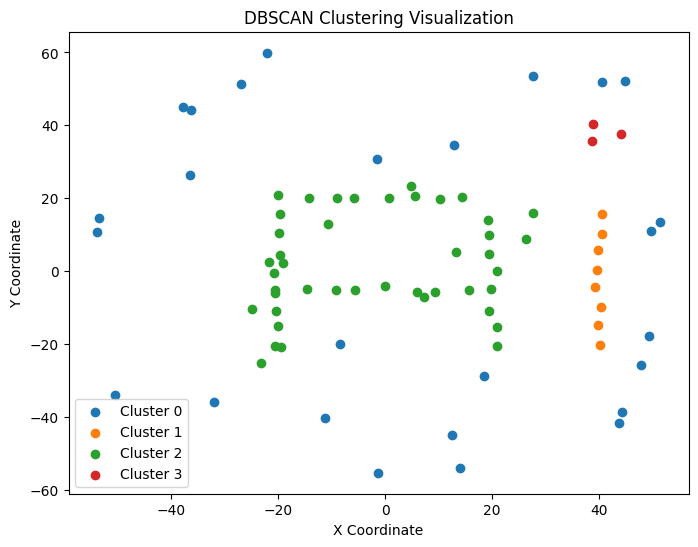

In [25]:
# Scatter plot of clusters
plt.figure(figsize=(8,6))

# Plot each cluster with a different color
for cluster_id in data['cluster'].unique():
    cluster_points = data[data['cluster'] == cluster_id]
    plt.scatter(cluster_points['x'], cluster_points['y'], label=f"Cluster {cluster_id}")

# Formatting
plt.xlabel('X Coordinate')
plt.ylabel('Y Coordinate')
plt.title('DBSCAN Clustering Visualization')
plt.legend()
plt.show()

**PROBLEM 6: DBSCAN on toy raw data**

Three toy 2D datasets are provided (or they can be obtained easily with scikit learn) circles; blobs, and moons. Run your own implementation of DBSCAN on these, in two phases.


In [71]:
# Start with generating our datasets
from sklearn.datasets import make_circles, make_blobs, make_moons

# Synthetic datasets
datasets = {
    'Circles': make_circles(n_samples=300, noise=0.05, factor=0.5, random_state=42),
    'Blobs': make_blobs(n_samples=300, centers=4, cluster_std=1.5, random_state=42),
    'Moons': make_moons(n_samples=300, noise=0.05, random_state=42)
}

In [74]:
# DBSCAN Parameters for each dataset
dbscan_params = {
    "Circles": {"epsilon": 0.2, "minPts": 5},
    "Blobs": {"epsilon": 1.5, "minPts": 6},
    "Moons": {"epsilon": 0.2, "minPts": 5},
}

# DBSCAN Algorithm
def dbscan(X, epsilon, minPts):
    """
    DBSCAN Implementation for clustering 2D points.
    """
    clusters = np.full(X.shape[0], -1)  # Initialize cluster labels as noise
    cluster_id = 0  # Start cluster IDs

    # Function to expand a cluster
    def expand_cluster(point_idx, cluster_id):
        neighbors = region_query(point_idx)
        if len(neighbors) < minPts:
            clusters[point_idx] = -1  # Mark as noise
            return False
        else:
            clusters[point_idx] = cluster_id
            queue = neighbors.copy()
            while queue:
                neighbor_idx = queue.pop()
                if clusters[neighbor_idx] == -1:  # Only update if still noise
                    clusters[neighbor_idx] = cluster_id
                    new_neighbors = region_query(neighbor_idx)
                    if len(new_neighbors) >= minPts:
                        queue.extend(new_neighbors)
            return True

    # Function to find neighbors within epsilon radius
    def region_query(point_idx):
        distances = np.linalg.norm(X - X[point_idx], axis=1)
        return np.where(distances <= epsilon)[0].tolist()

    # Process each point
    for i in range(X.shape[0]):
        if clusters[i] != -1:  # If already assigned, skip
            continue
        if expand_cluster(i, cluster_id):
            cluster_id += 1  # Create a new cluster

    return clusters

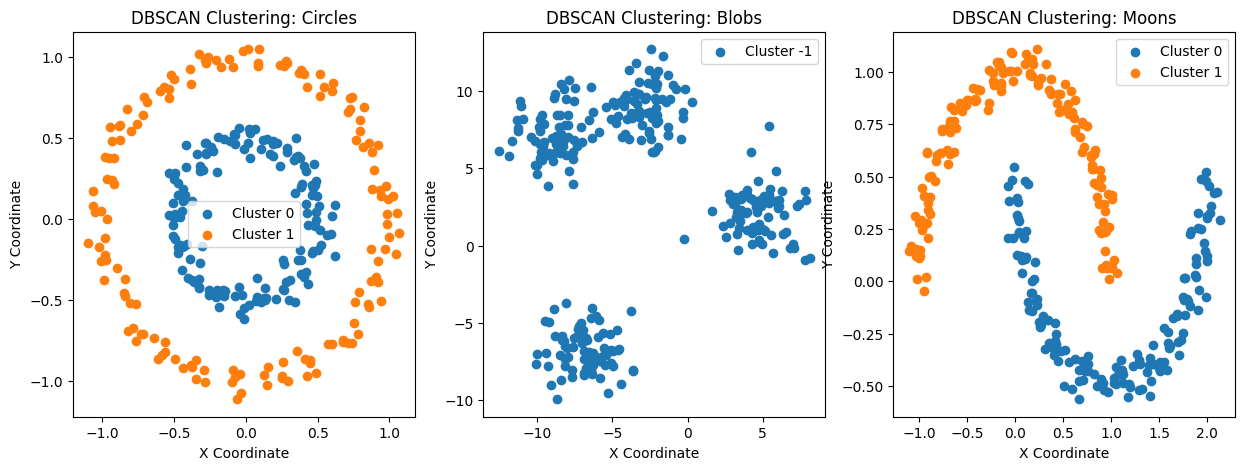

In [75]:
# Apply DBSCAN to Each Dataset
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (name, (X, _)) in enumerate(datasets.items()):
    labels = dbscan(X, epsilon, minPts)
    unique_clusters = np.unique(labels)

    # Plot Clusters
    for cluster in unique_clusters:
        cluster_points = X[labels == cluster]
        plt.subplot(1, 3, i + 1)
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster}")

    # Plot Formatting
    plt.title(f"DBSCAN Clustering: {name}")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()

plt.show()

**PROBLEM 7: DBSCAN on real data**

Run the DBSCAN algorithm on the 20NG dataset, and on the FASHION dataset, and the HouseHold dataset (see papers), and evaluate results. You need to implement both phases (1) neighborhoods creation, (2) DBSCAN.

Explain why/when it works, and speculate why/when not. You need to trial and error for parameters epsilon and MinPts

EXTRA CREDIT: Using class labels (cheating), try to remove/add points in curate the set for better DBSCAN runs

**PROBLEM 8: Hierarchical Clustering**

Implement hierarchical clustering. Start the bottom of the hierarchy with all point (or at least 5000 sampled) and build the hierarchy by repeatedly "joining the closest" clusters with avg_dist or single_dist criteria up to one big cluster (full hierarchy). Then decide how to cut it for K=2 or K=5 or K=10 clusters and evaluate. Run on moons dataset.

Optional: Run your hierarchical clustering on 20NG, sample 3000 documents.